<a href="https://colab.research.google.com/github/m-ary-t/CA03---Decision-Tree-Algorithm/blob/main/CA03_Decision_Tree_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

#For Visualizing Variables
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

#For Cramer's V Analysis of Correlation between Categorical Variables
from scipy.stats import chi2_contingency

#For Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

#For encoding the categorical variables
from sklearn.preprocessing import OrdinalEncoder

#For evaluating Decision Tree Performance
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)


In [2]:
df = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")


# 1. Data Source and Contents

**Q.1 Why does it makes sense to discretize columns for this problem?**


Discretizing continuous variables makes sense because decision tree algorithms split data based on thresholds that effectively turn continuous values into ranges (e.g., age ≤ 35 vs. > 35). Converting continuous variables into bins beforehand can:

1. **Reduces Noise and Variability** in raw numeric values.

2. **Simplifies Patterns** - the model detects broader trends rather than overfitting to tiny numeric differences.

3. **Improves Interpretability** - categories like “low,” “medium,” and “high” are easier to understand than raw numbers.

4. **Speeds Up Training** - fewer unique values mean fewer split points.

In datasets like salary prediction, exact numeric values (e.g., age 37 vs. 38) often matter less than which range they fall into.

**Q.2 What might be the issues (if any) if we DID NOT discretize the columns**

If continuous variables are not discretized:

1. **Risk of Overfitting** — the tree may create very specific splits based on small numeric differences that don’t generalize the variable well.

2. **Model Complexity** — more unique values lead to more potential split points, making the tree deeper and harder to interpret.

3. **Noise Sensitivity** — small measurement errors or outliers can strongly influence splits.

4. **Slower Computation** — evaluating many possible split thresholds increases training time.

# 2. Data Quality Analysis (DQA)

In [3]:
df

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0
...,...,...,...,...,...,...,...,...,...,...,...
48837,b. 31-40,e. High,b. Mid,a. = 0,b. Mid,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,test,0
48838,b. 31-40,b. Mid - Low,a. Low,a. = 0,b. Mid,b. 9-12,b. Mid,a. no income,c. 31-35 & 61-70,test,0
48839,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,test,0
48840,b. 31-40,b. Mid - Low,a. Low,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,test,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [5]:
df.describe()

,y
count,48842.000000
mean,0.239282
std,0.426649
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Checking for null values

In [6]:
df[df['hours_per_week_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [7]:
df[df['occupation_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [8]:
df[df['msr_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [9]:
df[df['capital_gl_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [10]:
df[df['race_sex_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [11]:
df[df['education_num_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [12]:
df[df['education_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [13]:
df[df['workclass_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [14]:
df[df['age_bin'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [15]:
df[df['flag'].isnull()]

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y


In [16]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
hours_per_week_bin,0,0.0
occupation_bin,0,0.0
msr_bin,0,0.0
capital_gl_bin,0,0.0
race_sex_bin,0,0.0
education_num_bin,0,0.0
education_bin,0,0.0
workclass_bin,0,0.0
age_bin,0,0.0
flag,0,0.0


### Results:

- No missing values in any variables

## List of Categorical Variables and Their Unique Values w/ Counts

In [17]:
cat_vars = df.dtypes[df.dtypes == "object"].index
cat_vars = cat_vars.to_list()
cat_vars.remove('flag')
cat_vars

['hours_per_week_bin',
 'occupation_bin',
 'msr_bin',
 'capital_gl_bin',
 'race_sex_bin',
 'education_num_bin',
 'education_bin',
 'workclass_bin',
 'age_bin']

### Summary Stats of Categorical Variables

In [18]:
def summarize_categoricals(df, cols= None, top_k=5, sort_by='missing_pct', ascending=False):
    if cols is None:
        cols = [c for c in df.columns if df[c].dtype == 'object' or pd.api.types.is_categorical_dtype(df[c]) or pd.api.types.is_bool_dtype(df[c])]
    if len(cols) == 0:
        raise ValueError("No categorical columns detected. Pass `cols=` explicitly if needed.")

    rows = []
    for col in cols:
        s = df[col]
        total = len(s)
        non_null = s.notna().sum()
        missing = total - non_null
        missing_pct = (missing / total * 100) if total else np.nan

        # Treat NaN as its own label for preview (but do not include in nunique)
        s_preview = s.astype(object).where(s.notna(), "NaN")
        vc = s_preview.value_counts(dropna=False)
        vc_pct = (vc / total * 100).round(2)

        # Most frequent category (including "NaN" if it is the most common)
        top_cat = vc.index[0] if len(vc) else np.nan
        top_freq = int(vc.iloc[0]) if len(vc) else np.nan
        top_pct = float(vc_pct.iloc[0]) if len(vc_pct) else np.nan

        # Number of unique non-null categories
        unique = s.nunique(dropna=True)

        # Build compact top-k preview string: `cat1 (45%), cat2 (20%), ...`
        top_items = [f"{str(idx)} ({pct:.1f}%)" for idx, pct in zip(vc.index[:top_k], vc_pct.values[:top_k])]
        top_k_str = ", ".join(top_items)

        rows.append({
            "column": col,
            "count": int(non_null),
            "missing": int(missing),
            "missing_pct": round(missing_pct, 2),
            "unique": int(unique),
            "mode": top_cat,
            "mode_freq": top_freq,
            "mode_pct": round(top_pct, 2) if not pd.isna(top_pct) else np.nan,
            f"top_{top_k}": top_k_str
        })

    out = pd.DataFrame(rows)
    # Nice default sort: highest missing% first (or customize via args)
    if sort_by is not None and sort_by in out.columns:
        out = out.sort_values(sort_by, ascending=ascending, kind="mergesort").reset_index(drop=True)

    # Formatting for display (optional)
    display_cols = ["column", "count", "missing", "missing_pct", "unique", "mode", "mode_freq", "mode_pct", f"top_{top_k}"]
    return out[display_cols]

summary = summarize_categoricals(df, cols= cat_vars, top_k=5, sort_by='missing_pct', ascending=False)
summary

,column,count,missing,missing_pct,unique,mode,mode_freq,mode_pct,top_5
0,hours_per_week_bin,48842,0,0.0,5,b. 31-40,26639,54.54,"b. 31-40 (54.5%), d. 41-50 & 61-70 (20.1%), a...."
1,occupation_bin,48842,0,0.0,5,c. Mid - Mid,13971,28.60,"c. Mid - Mid (28.6%), b. Mid - Low (26.5%), e...."
2,msr_bin,48842,0,0.0,3,c. High,22047,45.14,"c. High (45.1%), b. Mid (32.5%), a. Low (22.4%)"
3,capital_gl_bin,48842,0,0.0,3,a. = 0,42525,87.07,"a. = 0 (87.1%), c. > 0 (8.3%), b. < 0 (4.7%)"
4,race_sex_bin,48842,0,0.0,3,c. High,29737,60.88,"c. High (60.9%), b. Mid (33.7%), a. Low (5.4%)"
5,education_num_bin,48842,0,0.0,5,b. 9-12,30324,62.09,"b. 9-12 (62.1%), c. 13 (16.4%), a. 0-8 (13.1%)..."
6,education_bin,48842,0,0.0,5,b. Mid,30324,62.09,"b. Mid (62.1%), c. Bachelors (16.4%), a. Low (..."
7,workclass_bin,48842,0,0.0,2,b. income,46012,94.21,"b. income (94.2%), a. no income (5.8%)"
8,age_bin,48842,0,0.0,5,e. 40-55,13963,28.59,"e. 40-55 (28.6%), a. 0-25 (19.7%), c. 31-35 & ..."


### Summary Stats of Each Categorical Variable's Bin

In [19]:
def categorical_distribution_table(df, cat_vars, decimals=3):

    # Per-column stats
    meta_rows = []
    for col in cat_vars:
        s = df[col]
        meta_rows.append({
            "column": col,
            "unique": int(s.nunique(dropna=True)),
            "missing": int(s.isna().sum()),
            "count_non_missing": int(s.notna().sum()),
            "total_rows": len(s)
        })
    meta = pd.DataFrame(meta_rows)

    # Per-category counts/percent
    records = []
    for col in cat_vars:
        s = df[col]
        total = len(s)
        # Treat NaN as its own label for visibility; change to dropna=True if you don't want NaN shown
        s2 = s.astype(object).where(s.notna(), "NaN")
        counts = s2.value_counts(dropna=False)
        perc = (counts / total * 100)

        for cat, cnt in counts.items():
            records.append({
                "column": col,
                "category": cat,
                "count": int(cnt),
                "percent": round(perc.loc[cat], decimals)
            })

    dist = pd.DataFrame(records)

    # Merge per-category with per-column metadata
    out = dist.merge(meta, on="column", how="left")

    # Optional: Sort by column then descending percent
    out = out.sort_values(["column", "percent"], ascending=[True, False], kind="mergesort").reset_index(drop=True)
    return out

table_long = categorical_distribution_table(df, cat_vars, decimals=3)
display(table_long)

,column,category,count,percent,unique,missing,count_non_missing,total_rows
0,age_bin,e. 40-55,13963,28.588,5,0,48842,48842
1,age_bin,a. 0-25,9627,19.710,5,0,48842,48842
2,age_bin,c. 31-35 & 61-70,9291,19.023,5,0,48842,48842
3,age_bin,d. 36-40 & 56-60,8927,18.277,5,0,48842,48842
4,age_bin,b. 26-30 & 71-100,7034,14.402,5,0,48842,48842
5,capital_gl_bin,a. = 0,42525,87.066,3,0,48842,48842
6,capital_gl_bin,c. > 0,4035,8.261,3,0,48842,48842
7,capital_gl_bin,b. < 0,2282,4.672,3,0,48842,48842
8,education_bin,b. Mid,30324,62.086,5,0,48842,48842
9,education_bin,c. Bachelors,8025,16.431,5,0,48842,48842


In [20]:
for col in cat_vars:
    print(f"--- {col} ---")
    print("Unique categories:", df[col].nunique())
    print("Missing:", df[col].isna().sum())
    print()
    print("Count:")
    print(df[col].value_counts())
    print()
    print("Percentage Proportion:")
    print(df[col].value_counts(normalize=True).round(3)*100)
    print()


--- hours_per_week_bin ---
Unique categories: 5
Missing: 0

Count:
hours_per_week_bin
b. 31-40            26639
d. 41-50 & 61-70     9819
a. 0-30              7851
e. 51-60             3759
c. 71-100             774
Name: count, dtype: int64

Percentage Proportion:
hours_per_week_bin
b. 31-40            54.5
d. 41-50 & 61-70    20.1
a. 0-30             16.1
e. 51-60             7.7
c. 71-100            1.6
Name: proportion, dtype: float64

--- occupation_bin ---
Unique categories: 5
Missing: 0

Count:
occupation_bin
c. Mid - Mid     13971
b. Mid - Low     12947
e. High          12258
a. Low            7237
d. Mid - High     2429
Name: count, dtype: int64

Percentage Proportion:
occupation_bin
c. Mid - Mid     28.6
b. Mid - Low     26.5
e. High          25.1
a. Low           14.8
d. Mid - High     5.0
Name: proportion, dtype: float64

--- msr_bin ---
Unique categories: 3
Missing: 0

Count:
msr_bin
c. High    22047
b. Mid     15868
a. Low     10927
Name: count, dtype: int64

Percentage P

## Visualizing Variables

#### Frequency of Categorical Variables

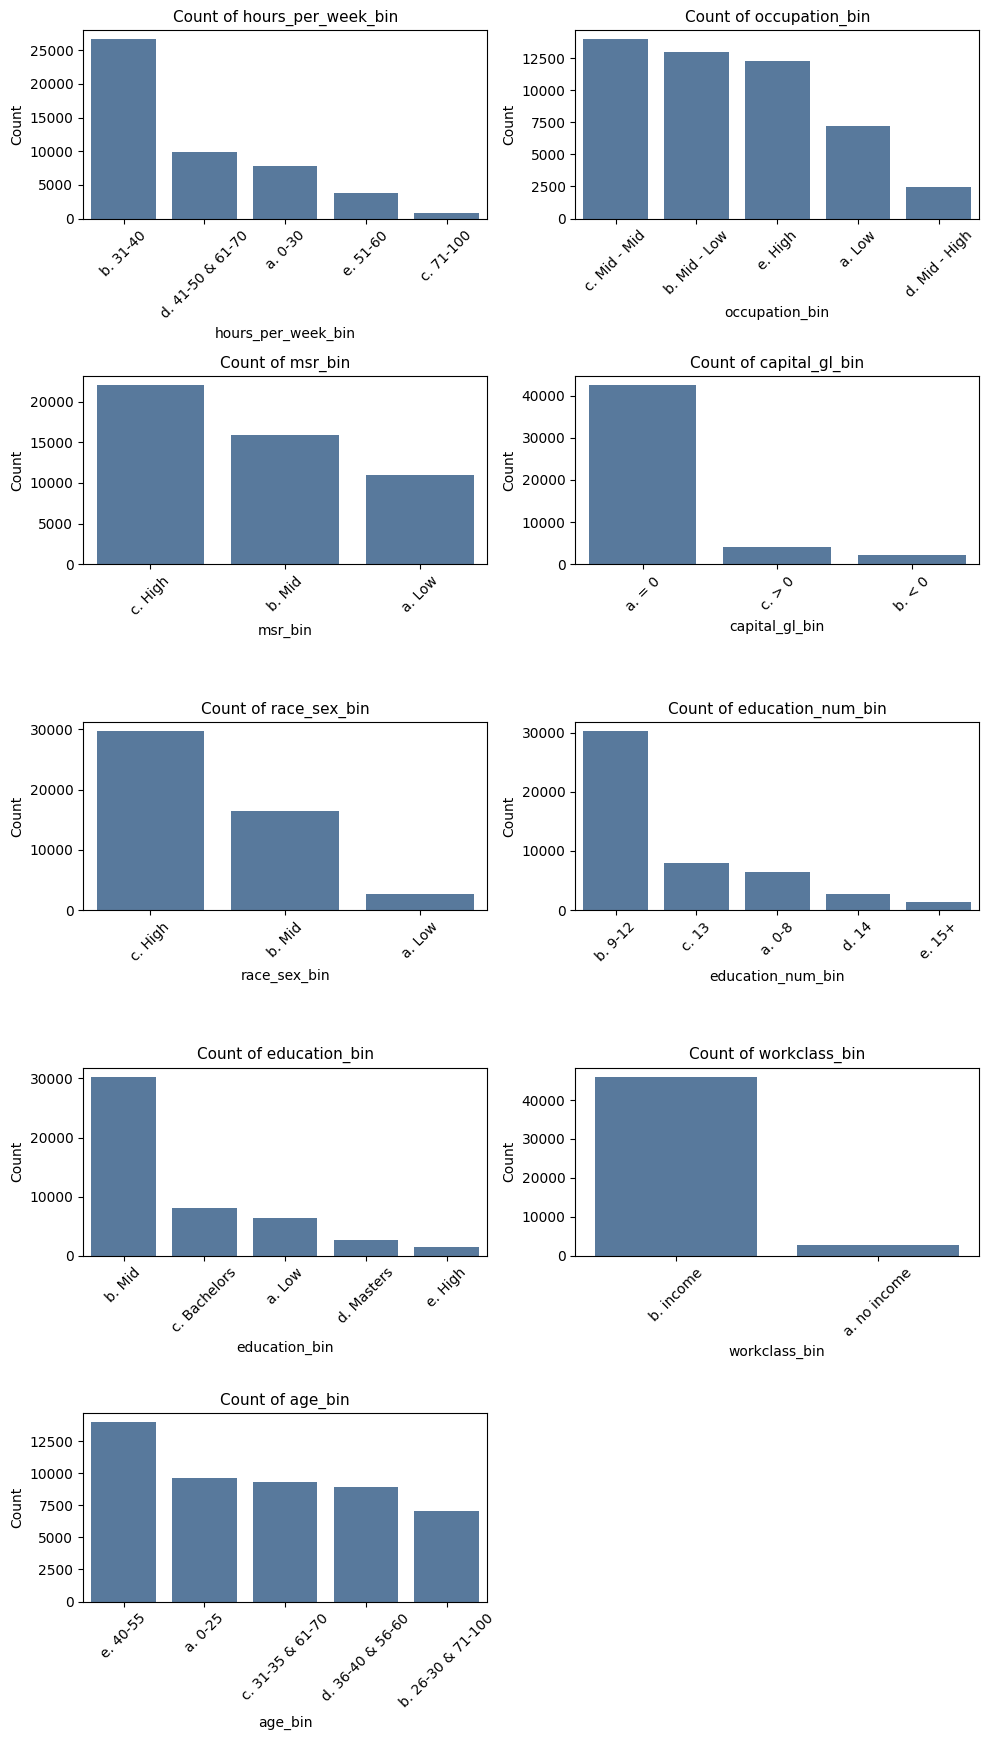

In [21]:
n_feats = len(cat_vars)

# Choose grid size (e.g., 2 columns); rows computed automatically
nr_cols = 2
nr_rows = math.ceil(n_feats / nr_cols)

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*5, nr_rows*3.5))
axs = axs if isinstance(axs, np.ndarray) else np.array([[axs]])  # ensure 2D array

# Flatten axes for easy indexing
axs = axs.flatten()

for i, col in enumerate(cat_vars):
    ax = axs[i]
    # Drop NaNs for counting; you can also show them explicitly if needed
    sns.countplot(x=col, data=df, order=df[col].value_counts(dropna=False).index, ax=ax, color="#4c78a8")
    ax.set_title(f"Count of {col}", fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    # Rotate labels if too long
    ax.tick_params(axis='x', rotation=45)

# Hide any leftover empty subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


#### Correlation of Categorical Variables

100% Stacked Bar Charts

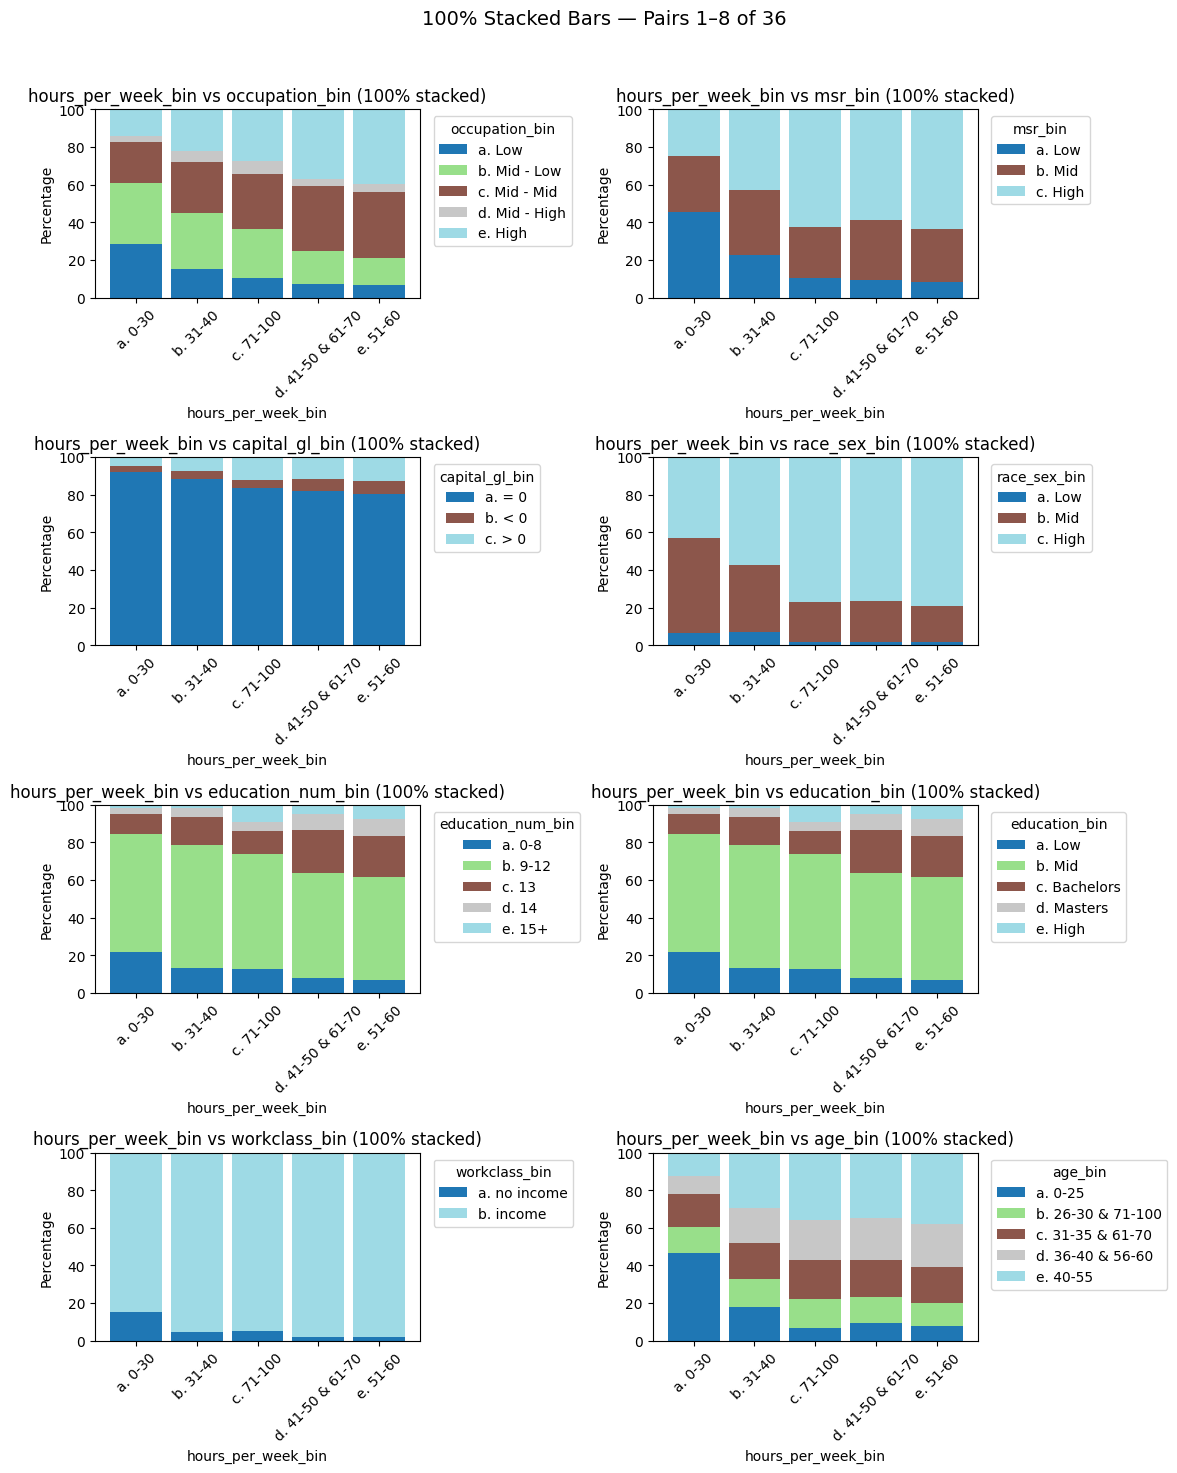

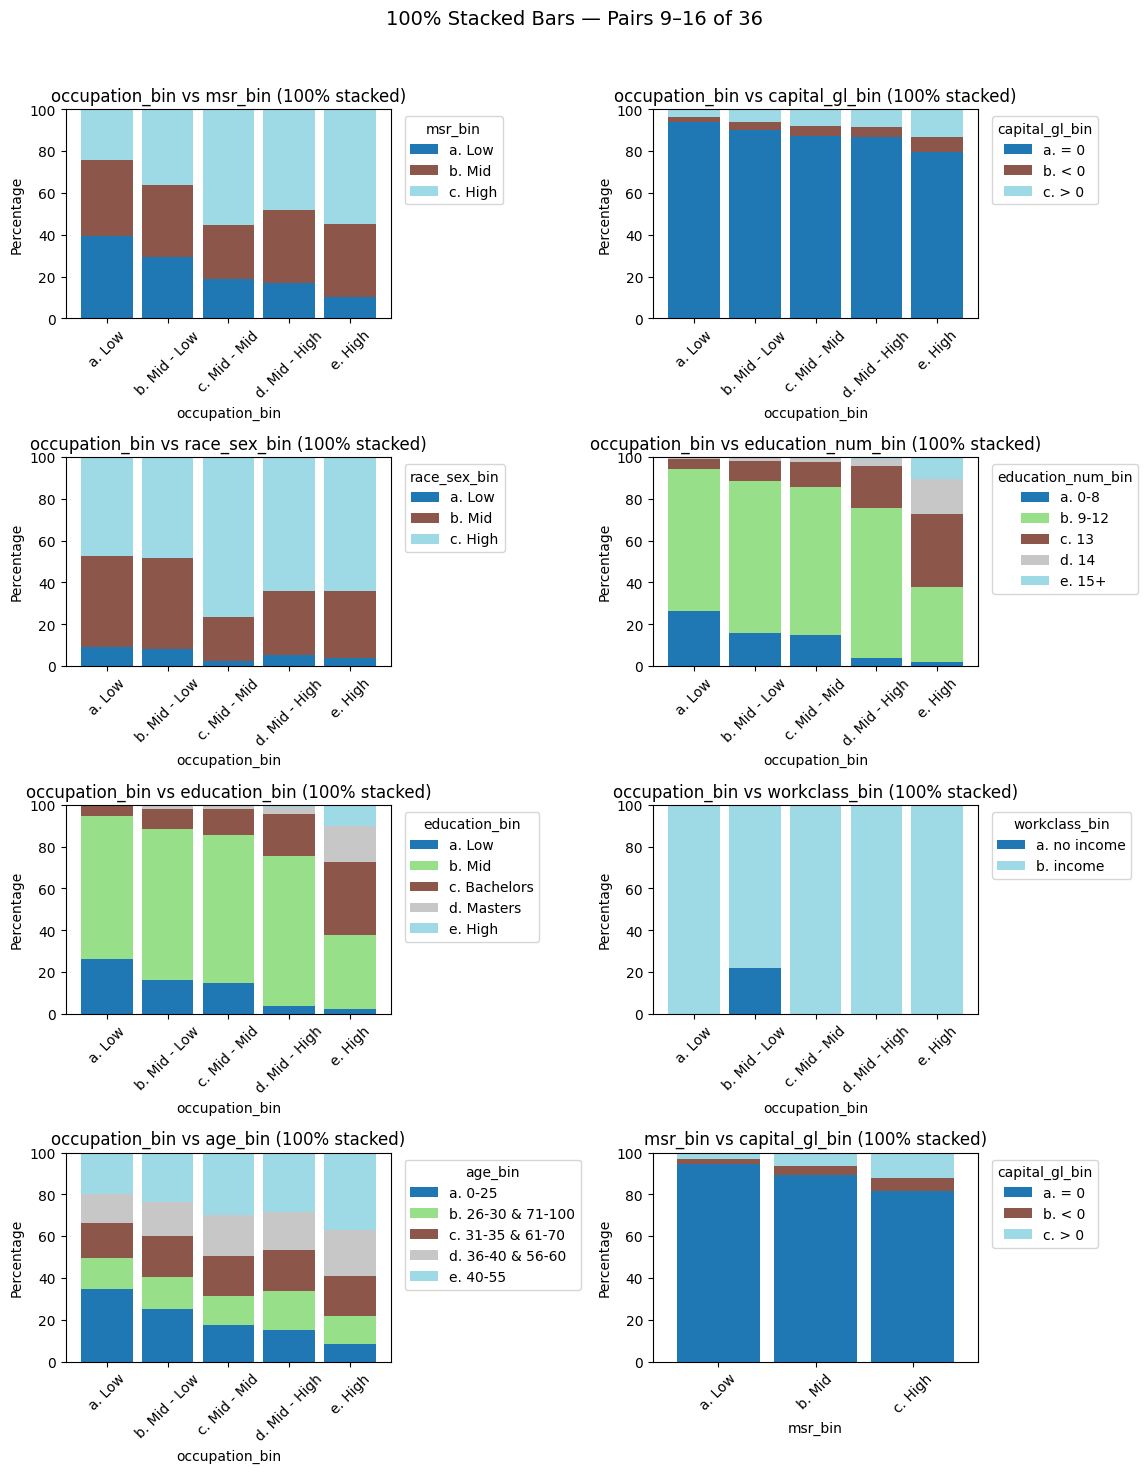

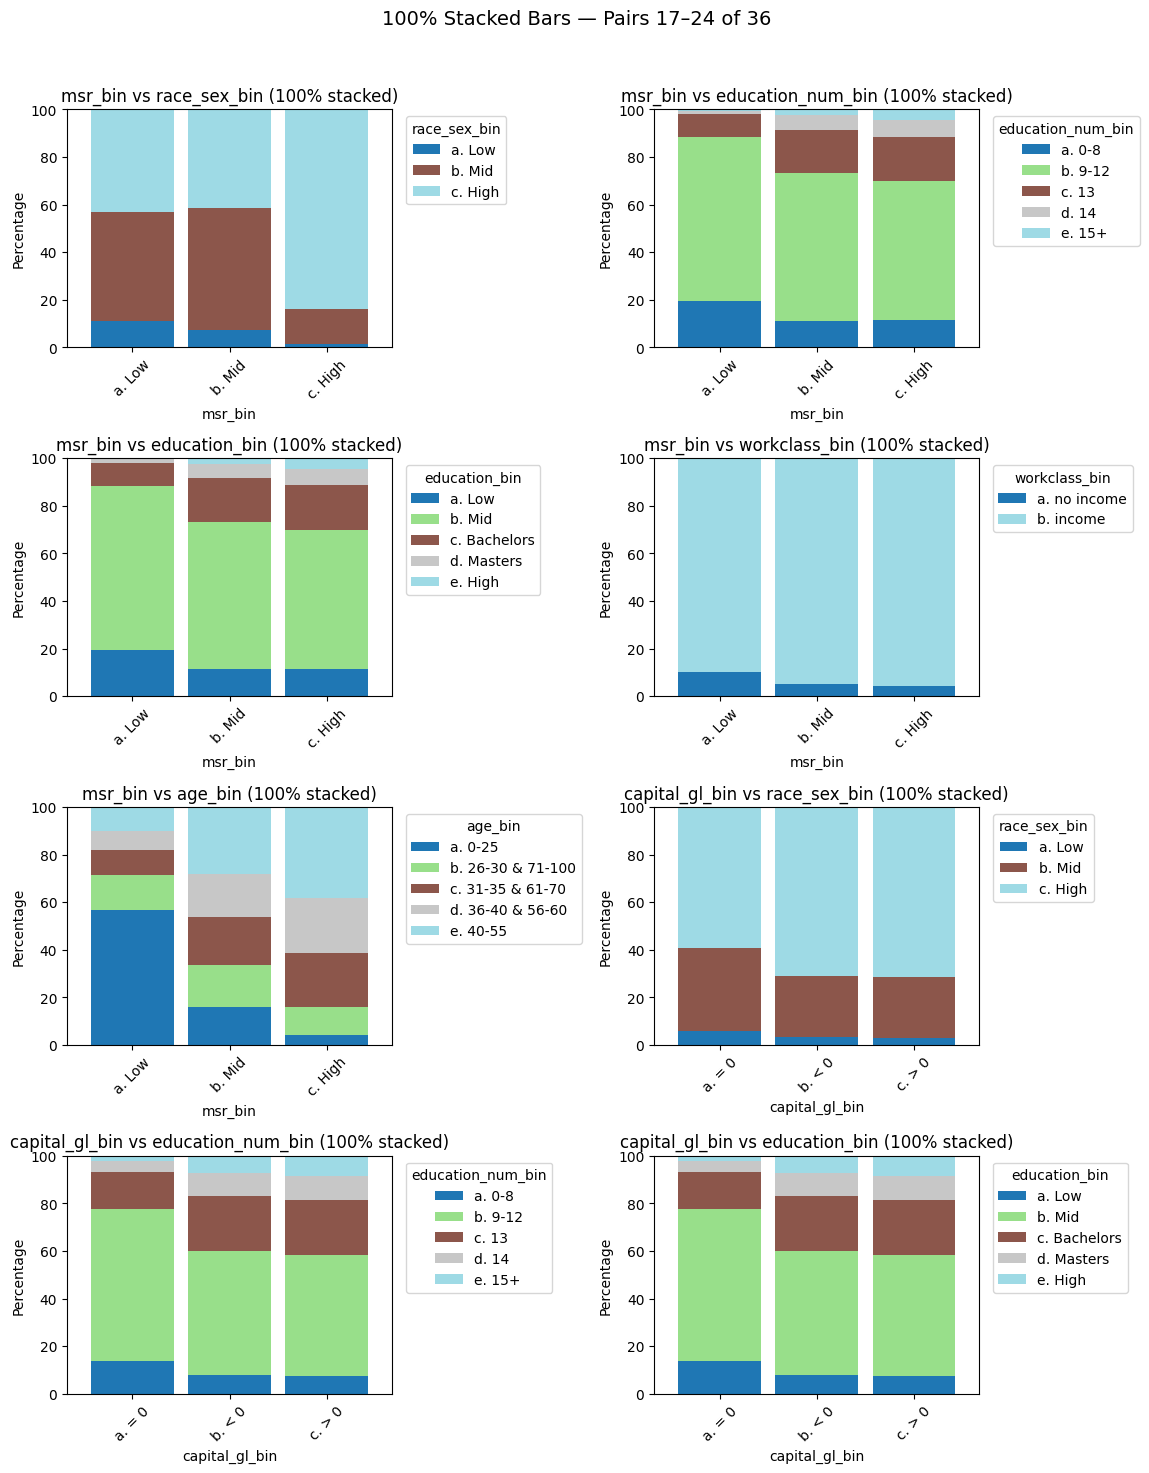

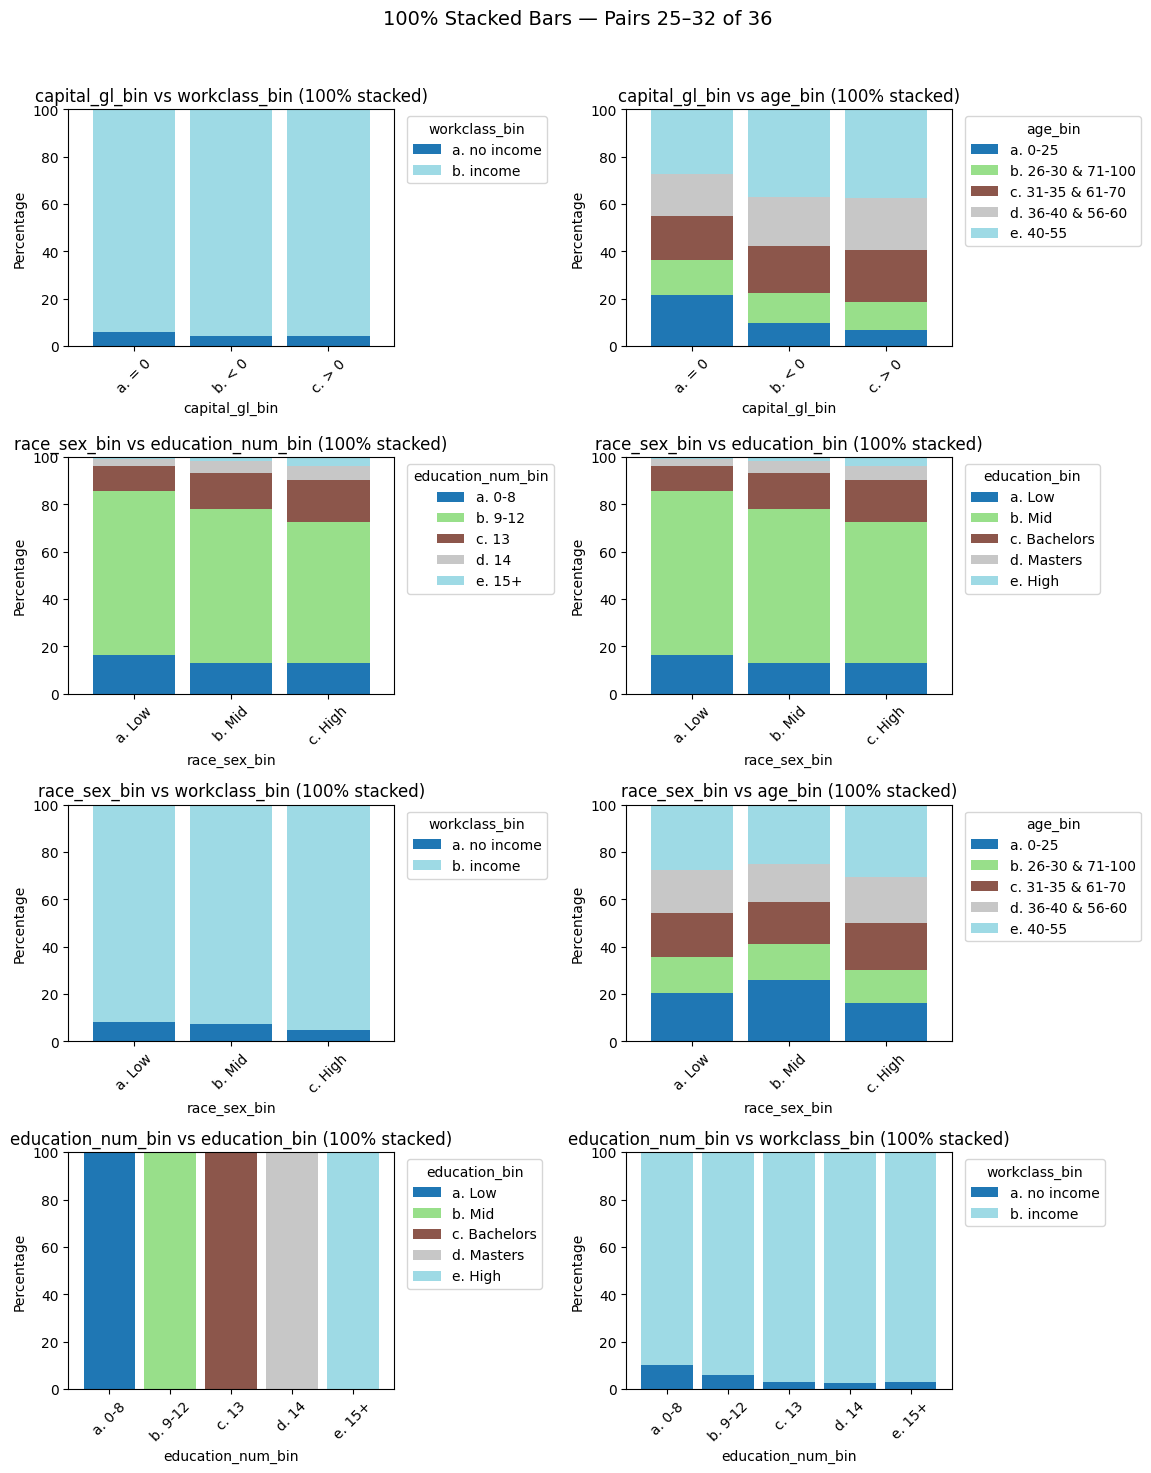

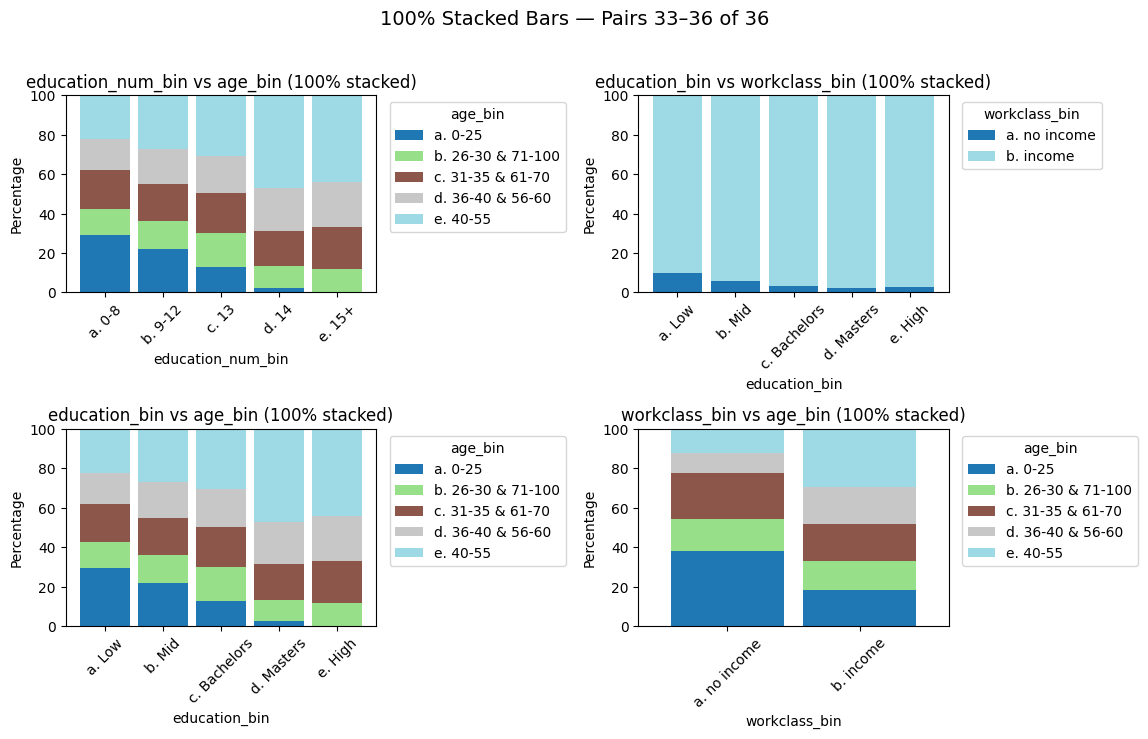

In [22]:
def plot_stacked_bar_100_pair(df, x, y, ax=None, top_k_x=15, top_k_y=15, include_nan=False, colormap='tab20'):
    a = df[x].astype(object)
    b = df[y].astype(object)

    if include_nan:
        a = a.where(a.notna(), "NaN")
        b = b.where(b.notna(), "NaN")
    else:
        mask = a.notna() & b.notna()
        a, b = a[mask], b[mask]

    if top_k_x is not None:
        a_levels = a.value_counts().head(top_k_x).index
        keep = a.isin(a_levels)
        a, b = a[keep], b[keep]
    if top_k_y is not None:
        b_levels = b.value_counts().head(top_k_y).index
        keep = b.isin(b_levels)
        a, b = a[keep], b[keep]

    ct = pd.crosstab(a, b, normalize='index') * 100
    ct = ct.sort_index()

    ax = ax or plt.gca()
    ct.plot(kind='bar', stacked=True, ax=ax, width=0.85, colormap=colormap)
    ax.set_ylabel("Percentage")
    ax.set_xlabel(x)
    ax.set_title(f"{x} vs {y} (100% stacked)")
    ax.legend(title=y, bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(0, 100)
    ax.tick_params(axis='x', rotation=45)

def grid_all_pairs_stacked_100(df, cat_vars, ncols=2, per_page=8, include_nan=False, top_k_x=15, top_k_y=15):
    pairs = list(itertools.combinations(cat_vars, 2))
    if not pairs:
        print("No pairs to plot.")
        return

    # Paginate pairs (per_page charts per figure)
    for start in range(0, len(pairs), per_page):
        chunk = pairs[start:start+per_page]
        n = len(chunk)
        nrows = math.ceil(n / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(5.8*ncols, 3.6*nrows))
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]

        for i, (x, y) in enumerate(chunk):
            plot_stacked_bar_100_pair(df, x, y, ax=axes[i], top_k_x=top_k_x, top_k_y=top_k_y, include_nan=include_nan)

        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(f"100% Stacked Bars — Pairs {start+1}–{start+n} of {len(pairs)}", y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

grid_all_pairs_stacked_100(df, cat_vars, ncols=2, per_page=8, include_nan=False, top_k_x=15, top_k_y=15)

Cramer's V Analysis

In [23]:
def cramers_v_from_crosstab(ct, bias_correction=True):
    chi2, p, dof, expected = chi2_contingency(ct, correction=False)
    n = ct.values.sum()
    r, c = ct.shape
    phi2 = chi2 / max(1, n)
    if not bias_correction:
        denom = max(1, min(r-1, c-1))
        return np.sqrt(phi2 / denom), p
    # Bias-corrected (Bergsma 2013; common in practice)
    phi2_corr = max(0.0, phi2 - ((c-1)*(r-1)) / max(1, n-1))
    r_corr = r - ((r-1)**2) / max(1, n-1)
    c_corr = c - ((c-1)**2) / max(1, n-1)
    denom = max(1e-12, min(r_corr-1, c_corr-1))
    return np.sqrt(phi2_corr / denom), p

def cramers_v_matrix_safe(df, cols, include_nan=False, verbose=True):
    # Keep only valid, 1-D Series columns that exist in df
    cols = list(dict.fromkeys(cols))  # de-dup while keeping order
    valid_cols, dropped = [], []
    for c in cols:
        if c not in df.columns:
            dropped.append((c, "missing"))
            continue
        s = df[c]
        if getattr(s, "ndim", 1) != 1:
            dropped.append((c, f"ndim={getattr(s,'ndim',None)}"))
            continue
        valid_cols.append(c)

    if verbose and dropped:
        print("Skipping invalid columns:", dropped)

    if not valid_cols:
        raise ValueError("No valid 1-D columns to process.")

    data = df[valid_cols].copy()
    if include_nan:
        data = data.astype(object).where(data.notna(), "NaN")

    V = pd.DataFrame(index=valid_cols, columns=valid_cols, dtype=float)
    P = pd.DataFrame(index=valid_cols, columns=valid_cols, dtype=float)
    skipped_pairs = []

    for i, c1 in enumerate(valid_cols):
        for j, c2 in enumerate(valid_cols):
            if j < i:
                continue
            sub = data[[c1, c2]].dropna() if not include_nan else data[[c1, c2]]
            try:
                # need 1-D Series for crosstab
                s1 = sub[c1]
                s2 = sub[c2]
                if s1.empty or s2.empty:
                    v, p = np.nan, np.nan
                else:
                    ct = pd.crosstab(s1.astype(object), s2.astype(object))
                    if ct.size == 0 or ct.shape[0] < 2 or ct.shape[1] < 2:
                        v, p = 0.0, np.nan  # degenerate table
                    else:
                        v, p = cramers_v_from_crosstab(ct, bias_correction=True)
            except Exception as e:
                skipped_pairs.append((c1, c2, str(e)))
                v, p = np.nan, np.nan

            V.loc[c1, c2] = V.loc[c2, c1] = v
            P.loc[c1, c2] = P.loc[c2, c1] = p

    np.fill_diagonal(V.values, 1.0)
    np.fill_diagonal(P.values, np.nan)
    if verbose and skipped_pairs:
        print("Skipped pairs due to errors:", skipped_pairs)
    return V, P

# ---- Run it ----
li_cat_feats = list(cat_vars)  # your original
V, P = cramers_v_matrix_safe(df, li_cat_feats, include_nan=False, verbose=True)

# Rank pairs by strength
ranked = (V.where(~np.eye(V.shape[0], dtype=bool))
            .stack()
            .sort_values(ascending=False)
            .reset_index())
ranked.columns = ["var1", "var2", "cramers_v"]
ranked

Skipped pairs due to errors: [('hours_per_week_bin', 'hours_per_week_bin', '2'), ('occupation_bin', 'occupation_bin', '2'), ('msr_bin', 'msr_bin', '2'), ('capital_gl_bin', 'capital_gl_bin', '2'), ('race_sex_bin', 'race_sex_bin', '2'), ('education_num_bin', 'education_num_bin', '2'), ('education_bin', 'education_bin', '2'), ('workclass_bin', 'workclass_bin', '2'), ('age_bin', 'age_bin', '2')]


,var1,var2,cramers_v
0,education_num_bin,education_bin,1.000000
1,education_bin,education_num_bin,1.000000
2,workclass_bin,occupation_bin,0.411260
3,occupation_bin,workclass_bin,0.411260
4,msr_bin,age_bin,0.380123
...,...,...,...
67,race_sex_bin,workclass_bin,0.062540
68,capital_gl_bin,race_sex_bin,0.059056
69,race_sex_bin,capital_gl_bin,0.059056
70,capital_gl_bin,workclass_bin,0.022092


In [24]:
ranked[ranked['cramers_v'] > .2]

,var1,var2,cramers_v
0,education_num_bin,education_bin,1.000000
1,education_bin,education_num_bin,1.000000
2,workclass_bin,occupation_bin,0.411260
3,occupation_bin,workclass_bin,0.411260
4,msr_bin,age_bin,0.380123
5,age_bin,msr_bin,0.380123
6,race_sex_bin,msr_bin,0.305368
7,msr_bin,race_sex_bin,0.305368
8,occupation_bin,education_bin,0.276979
9,occupation_bin,education_num_bin,0.276979


**Correlated Categorical Variables**

Based on the 100% Stacked Bar Charts of the categorical variables, as well as their Cramer's V scores, these variables have the following correlations:

- **Very Strong Correlation**:
  - 'education_bin' and 'education_num_bin'
- **Strong Correlation**:
  - 'workclass_bin' and 'occupation_bin'
- **Moderate Correlation**:
  - 'msr_bin' and 'age_bin'
- **Low-Moderate Correlation**:
  - 'race_sex_bin' and 'msr_bin'
  - 'occupation_bin' and 'education_bin'/'education_num_bin'

**Recommendations**
- We considered removing either 'education_bin' and 'education_num_bin', but we decided to keep them both since they use different labels to classify their bins (i.e. one is numerical and represents the amount of years they were in school and the other is "low", "mid", "high", etc.)


## Encoding Categorical Variables

Scikit-learn does not support categorical variables yet, so we need to encode the categories of each categorical variable.

First we will make sure the categories of each variable are in the correct order. Then we will make a copy of our dataframe (in order to keep the original unencoded dataframe in case we need it) an encode the coppied dataframe.

In [25]:
#Checking the order of the columns and their bins in cat_vars

for col in cat_vars:
    print(f"\nColumn: {col}")
    print(list(df[col].dropna().unique()))


Column: hours_per_week_bin
['b. 31-40', 'a. 0-30', 'd. 41-50 & 61-70', 'c. 71-100', 'e. 51-60']

Column: occupation_bin
['b. Mid - Low', 'e. High', 'a. Low', 'c. Mid - Mid', 'd. Mid - High']

Column: msr_bin
['b. Mid', 'c. High', 'a. Low']

Column: capital_gl_bin
['c. > 0', 'a. = 0', 'b. < 0']

Column: race_sex_bin
['c. High', 'b. Mid', 'a. Low']

Column: education_num_bin
['c. 13', 'b. 9-12', 'a. 0-8', 'd. 14', 'e. 15+']

Column: education_bin
['c. Bachelors', 'b. Mid', 'a. Low', 'd. Masters', 'e. High']

Column: workclass_bin
['b. income', 'a. no income']

Column: age_bin
['d. 36-40 & 56-60', 'e. 40-55', 'b. 26-30 & 71-100', 'c. 31-35 & 61-70', 'a. 0-25']


In [26]:
# Logically ordering the categories (low → high) for each column:

cat_vars = ['hours_per_week_bin','occupation_bin','msr_bin','capital_gl_bin',
            'race_sex_bin','education_num_bin','education_bin','workclass_bin','age_bin']

categories = [
    # hours_per_week_bin
    ["a. 0-30", "b. 31-40", "d. 41-50 & 61-70", "e. 51-60", "c. 71-100"],

    # occupation_bin
    ["a. Low", "b. Mid - Low","c. Mid - Mid","d. Mid - High","e. High"],

    # msr_bin (Marriage Status & Relationships)
    ["a. Low","b. Mid","c. High"],

    # capital_gl_bin (financial logic: loss < zero < gain)
    ["b. < 0", "a. = 0","c. > 0"],

    # race_sex_bin
    ["a. Low","b. Mid","c. High"],

    # education_num_bin (increasing years)
    ["a. 0-8","b. 9-12","c. 13","d. 14","e. 15+"],

    # education_bin (increasing attainment)
    ["a. Low","b. Mid","c. Bachelors","d. Masters","e. High"],

    # workclass_bin
    ["a. no income","b. income"],

    # age_bin (progression by approximate age)
    ["a. 0-25","b. 26-30 & 71-100","c. 31-35 & 61-70","d. 36-40 & 56-60","e. 40-55"]
]

In [27]:
# Build the encoder
encoder = OrdinalEncoder(
    categories=categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1)

# Fit the encoder on the full dataset
df_for_fit = df.copy()
for c in cat_vars:
    df_for_fit[c] = df_for_fit[c].astype(str)

encoder.fit(df_for_fit[cat_vars])

# Create a new encoded copy and keep the original df unchanged
df_encoded = df.copy()
for c in cat_vars:
    df_encoded[c] = df_encoded[c].astype(str)

df_encoded[cat_vars] = encoder.transform(df_encoded[cat_vars])

df_encoded

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,train,0
1,0.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,4.0,train,0
2,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,train,0
3,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,4.0,train,0
4,1.0,4.0,2.0,1.0,0.0,2.0,2.0,1.0,1.0,train,0
...,...,...,...,...,...,...,...,...,...,...,...
48837,1.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0,test,0
48838,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,test,0
48839,2.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,test,0
48840,1.0,1.0,0.0,2.0,2.0,2.0,2.0,1.0,4.0,test,0


# Splitting Training and Testing Data

In [28]:
train = df_encoded[df_encoded['flag'] == 'train']
test = df_encoded[df_encoded['flag'] == 'test']

In [29]:
x_train = train.drop(columns=['y', 'flag'])
y_train = train['y']

x_test  = test.drop(columns=['y', 'flag'])
y_test  = test['y']


# 3. Build Decision Tree Classifier Models

In [30]:
dtree = DecisionTreeClassifier(max_depth=10, random_state=101,
                               max_features=None, min_samples_leaf=15)

dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)

# 4. Evaluate Decision Tree Performance

### Confusion Matrix

Confusion Matrix (rows=true, cols=pred):
[[11571   864]
 [ 1653  2193]]
TN=11571, FP=864, FN=1653, TP=2193


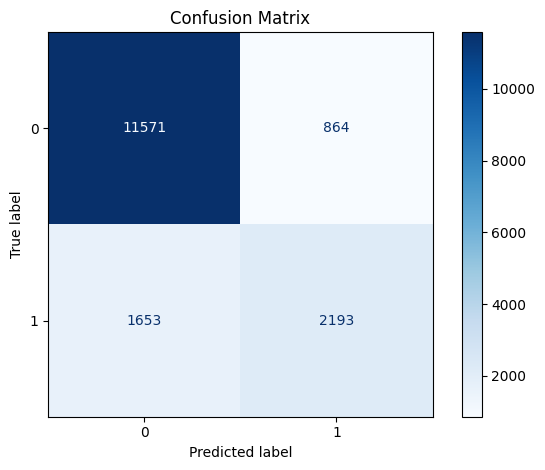

In [31]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix (rows=true, cols=pred):")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Optional: plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### Accuracy, Precision, Recall, F1

In [32]:
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)   # positive class defaults to max(label) unless you set pos_label=...
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 score : {f1:.4f}")

Accuracy : 0.8454
Precision: 0.7174
Recall   : 0.5702
F1 score : 0.6354


In [33]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12435
           1       0.72      0.57      0.64      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.75      0.77     16281
weighted avg       0.84      0.85      0.84     16281



**Model Performance Interpretation**

- The model is percise in predicting "0" 88% of the time, correctly predicted 93% of the "0"'s in the data, and has a high f1-score of 90%!
- The model is percise in prediciting "1" 72% of the time, but is only able to guess 57% of the "1"'s in the data correctly, and has an okay f1-score of 64%

## **5. Tune Decision Tree Performance**

In [34]:
# Define a function that trains ONE tree and returns performance metrics
def score_tree(params, x_train, y_train, x_test, y_test):

    # Create a Decision Tree model using the given hyperparameters
    # random_state keeps results consistent every run
    # **params "unpacks" the hyperparameter dictionary into the model
    model = DecisionTreeClassifier(random_state=101, **params)

    # Train the model on training data
    model.fit(x_train, y_train)

    # Predict labels on test data
    y_pred = model.predict(x_test)

    # Return one row of results as a dictionary (easy to convert into a table)
    return {
        # Save hyperparameters used for this run
        "Split Criteria": params.get("criterion", "gini"),
        "Maximum Features": params.get("max_features", None),
        "Minimum Sample Leaf": params.get("min_samples_leaf", 1),
        "Maximum Depth": params.get("max_depth", None),

        # Save evaluation metrics for this run
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0)
    }


## RUN 1: Split Criteria (Entropy vs Gini)

In [35]:
# Create an empty list to store results for Run 1
run1_results = []

# Try both split criteria options required by the assignment
for crit in ["entropy", "gini"]:

    # Set hyperparameters for this run (only criterion changes)
    params = {"criterion": crit}

    # Train + evaluate and store results
    run1_results.append(score_tree(params, x_train, y_train, x_test, y_test))

# Convert results into a DataFrame (table)
run1_table = pd.DataFrame(run1_results)

# Sort table so best accuracy appears at the top
run1_table = run1_table.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# Display Run 1 table
run1_table


,Split Criteria,Maximum Features,Minimum Sample Leaf,Maximum Depth,Accuracy,Recall,Precision,F1
0,gini,None,1,None,0.836926,0.554082,0.693911,0.616163
1,entropy,None,1,None,0.836374,0.553042,0.692383,0.614918


Both Gini and Entropy produced very similar performance, but Gini achieved slightly higher accuracy and marginally better overall metrics. Therefore, Gini was selected as the split criterion for the next tuning steps since it performed best on this dataset.

## RUN 2: Minimum Sample Leaf (use best criterion from Run 1)

In [36]:
# Pick the best criterion from Run 1 (top row after sorting)
best_criterion = run1_table.loc[0, "Split Criteria"]

# Print it so you can see what won
print("Best Split Criteria from Run 1:", best_criterion)

# Create empty list to store results for Run 2
run2_results = []

# Try different min_samples_leaf values (required list from assignment style)
for leaf in [5, 10, 15, 20, 25, 30, 35, 40]:

    # Set hyperparameters: keep best criterion, vary leaf size
    params = {
        "criterion": best_criterion,
        "min_samples_leaf": leaf
    }

    # Train + evaluate and store results
    run2_results.append(score_tree(params, x_train, y_train, x_test, y_test))

# Convert results into a DataFrame table
run2_table = pd.DataFrame(run2_results)

# Sort by accuracy (best at top)
run2_table = run2_table.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# Display Run 2 table
run2_table


Best Split Criteria from Run 1: gini


,Split Criteria,Maximum Features,Minimum Sample Leaf,Maximum Depth,Accuracy,Recall,Precision,F1
0,gini,None,30,None,0.843007,0.566563,0.710235,0.630315
1,gini,None,25,None,0.842946,0.568123,0.709185,0.630865
2,gini,None,35,None,0.842639,0.562142,0.711184,0.627941
3,gini,None,20,None,0.841902,0.567603,0.705559,0.629107
4,gini,None,15,None,0.841533,0.559802,0.708224,0.625327
5,gini,None,40,None,0.841103,0.544462,0.714920,0.618155
6,gini,None,5,None,0.839506,0.556682,0.702197,0.621030
7,gini,None,10,None,0.839445,0.555122,0.702765,0.620279


In Run 2, the minimum number of samples required in each leaf node was varied while keeping the Gini split criterion fixed. Increasing the minimum sample leaf generally improved performance by reducing overfitting, and the best accuracy was achieved when min_samples_leaf = 30. This suggests that allowing slightly larger leaf nodes helped the model generalize better to unseen data

## RUN 3: Maximum Features (use best criterion + best leaf)

In [37]:
# Pick best min_samples_leaf from Run 2 (top row after sorting)
best_leaf = int(run2_table.loc[0, "Minimum Sample Leaf"])

# Print it so you can see what won
print("Best Minimum Sample Leaf from Run 2:", best_leaf)

# Create empty list to store results for Run 3
run3_results = []

# Try max_features options (mix of common + float fractions)
# None = use all features
# "sqrt" = common default for classification
# floats = fraction of total features
for mf in ["sqrt", None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:

    # Set hyperparameters: keep best criterion + best leaf, vary max_features
    params = {
        "criterion": best_criterion,
        "min_samples_leaf": best_leaf,
        "max_features": mf
    }

    # Train + evaluate and store results
    run3_results.append(score_tree(params, x_train, y_train, x_test, y_test))

# Convert results into a DataFrame table
run3_table = pd.DataFrame(run3_results)

# Sort by accuracy (best at top)
run3_table = run3_table.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# Display Run 3 table
run3_table


Best Minimum Sample Leaf from Run 2: 30


,Split Criteria,Maximum Features,Minimum Sample Leaf,Maximum Depth,Accuracy,Recall,Precision,F1
0,gini,sqrt,30,None,0.844604,0.577743,0.710358,0.637224
1,gini,0.4,30,None,0.844604,0.577743,0.710358,0.637224
2,gini,0.6,30,None,0.844543,0.554342,0.722957,0.627520
3,gini,0.7,30,None,0.843499,0.550442,0.721049,0.624300
4,gini,0.8,30,None,0.843191,0.569683,0.709291,0.631867
5,gini,None,30,None,0.843007,0.566563,0.710235,0.630315
6,gini,0.5,30,None,0.841165,0.572283,0.700509,0.629937
7,gini,0.3,30,None,0.833733,0.525741,0.696041,0.599022


In Run 3, the number of features considered at each split (max_features) was varied while keeping the best split criterion (Gini) and minimum sample leaf (30) fixed. The results show that using sqrt (and similarly 0.4) produced the highest accuracy and overall balanced performance. This indicates that limiting the number of features evaluated at each split helps reduce overfitting and improves the model’s generalization.

## RUN 4: Maximum Depth

In [38]:
# Select best max_features from Run 3
best_max_features = run3_table.loc[0, "Maximum Features"]

print("Best Maximum Features from Run 3:", best_max_features)

Best Maximum Features from Run 3: sqrt


In [39]:
# ---------------------------------------------
# RUN 4: Tune Maximum Depth
# We KEEP the best settings from previous runs:
#   - best criterion = gini
#   - best min_samples_leaf = 30
#   - best max_features = sqrt (from Run 3)
# Now we ONLY change max_depth
# ---------------------------------------------

# Store results from Run 4
run4_results = []

# Try multiple tree depths
# Small depth = simpler tree
# Large depth = more complex tree
for depth in [2, 4, 6, 8, 10, 12, 14, 16]:

    # Define model parameters
    params = {
        "criterion": best_criterion,        # gini
        "min_samples_leaf": best_leaf,      # 30
        "max_features": best_max_features,  # sqrt
        "max_depth": depth                  # value we are testing
    }

    # Train model + compute metrics using helper function
    run4_results.append(
        score_tree(params, x_train, y_train, x_test, y_test)
    )

# Convert results into a table
run4_table = pd.DataFrame(run4_results)

# Sort so best accuracy appears first
run4_table = run4_table.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# Display results
run4_table


,Split Criteria,Maximum Features,Minimum Sample Leaf,Maximum Depth,Accuracy,Recall,Precision,F1
0,gini,sqrt,30,10,0.843683,0.577483,0.707100,0.635752
1,gini,sqrt,30,8,0.841533,0.560062,0.708087,0.625436
2,gini,sqrt,30,14,0.841287,0.568903,0.702633,0.628736
3,gini,sqrt,30,12,0.840120,0.568643,0.698499,0.626917
4,gini,sqrt,30,16,0.837172,0.549142,0.697260,0.614400
5,gini,sqrt,30,4,0.828389,0.449558,0.718620,0.553103
6,gini,sqrt,30,6,0.827406,0.449038,0.714227,0.551405
7,gini,sqrt,30,2,0.769670,0.496620,0.512889,0.504624


In Run 4, the maximum depth of the decision tree was varied while keeping previously optimized parameters fixed. Performance improved as depth increased until reaching a maximum accuracy at depth = 10, after which performance slightly declined. This indicates that a moderate tree depth provides the best balance between model complexity and generalization, reducing both underfitting and overfitting.

# Q.3 Decision Tree Hyper-parameter variation vs.performance

### GRAPH 1: Minimum Sample Leaf vs Accuracy

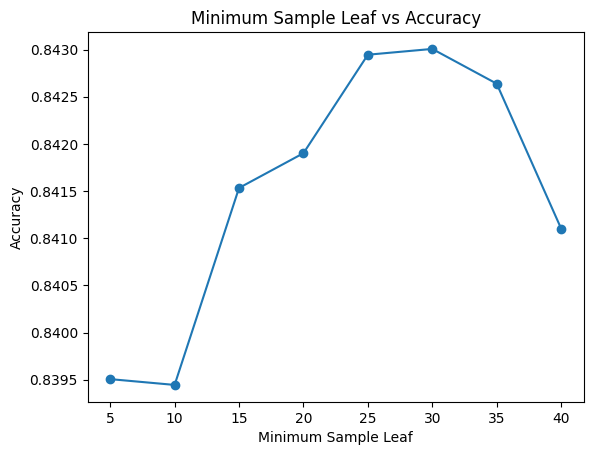

In [40]:
# Sort values so graph looks clean left → right
plot_run2 = run2_table.sort_values("Minimum Sample Leaf")

plt.figure()
plt.plot(
    plot_run2["Minimum Sample Leaf"],
    plot_run2["Accuracy"],
    marker="o"
)

plt.xlabel("Minimum Sample Leaf")
plt.ylabel("Accuracy")
plt.title("Minimum Sample Leaf vs Accuracy")

plt.show()


Accuracy increases as min_samples_leaf grows from 5 to around 25–30, peaking at 30. After 30, accuracy slightly drops (35–40), suggesting that very large leaf sizes start to underfit. Therefore, min_samples_leaf = 30 is selected as the best value.

### GRAPH 2: Maximum Features vs Accuracy

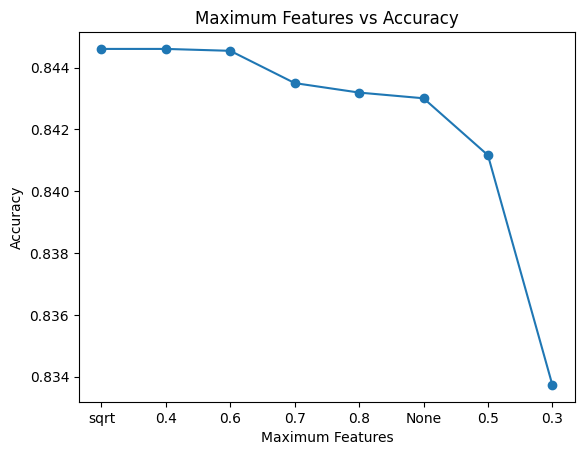

In [41]:
plot_run3 = run3_table.copy()

# Convert values to string for plotting
plot_run3["Maximum Features"] = plot_run3["Maximum Features"].astype(str)

plt.figure()
plt.plot(
    plot_run3["Maximum Features"],
    plot_run3["Accuracy"],
    marker="o"
)

plt.xlabel("Maximum Features")
plt.ylabel("Accuracy")
plt.title("Maximum Features vs Accuracy")

plt.show()


Accuracy is highest when using sqrt (and similarly around 0.4–0.6), showing that limiting the number of features considered at each split improves generalization. When too few features are used (e.g., 0.3), accuracy drops noticeably, indicating underfitting. Therefore, max_features = sqrt is selected as the optimal value.

### GRAPH 3: Maximum Depth vs Accuracy

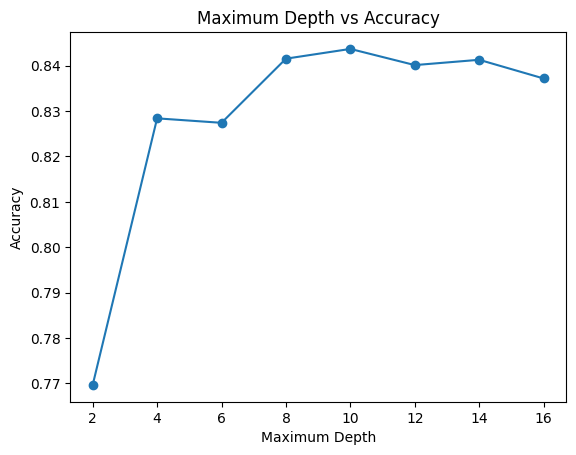

In [42]:
plot_run4 = run4_table.sort_values("Maximum Depth")

plt.figure()
plt.plot(
    plot_run4["Maximum Depth"],
    plot_run4["Accuracy"],
    marker="o"
)

plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.title("Maximum Depth vs Accuracy")

plt.show()


Accuracy improves as the tree depth increases, reaching its highest value at max_depth = 10. Beyond this point, accuracy slightly decreases, indicating that deeper trees begin to overfit the training data. Therefore, maximum depth = 10 is selected as the optimal value because it provides the best balance between model complexity and generalization.

### Performance Table

In [43]:
# Q3 — Build performance table for Maximum Depth

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import pandas as pd

# store results here
results = []

# depth values required in assignment
max_depth_options = [2,4,6,8,10,12,14,16]

for depth in max_depth_options:

    # build model using BEST parameters from previous runs
    model = DecisionTreeClassifier(
        criterion=best_criterion,      # gini
        min_samples_leaf=best_leaf,    # 30
        max_features=best_max_features,# sqrt
        max_depth=depth,
        random_state=101
    )

    # train model
    model.fit(x_train, y_train)

    # predictions
    y_pred = model.predict(x_test)

    # compute metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # save results
    results.append([depth, acc, rec, prec, f1])

# create final table
q3_table = pd.DataFrame(
    results,
    columns=["Maximum Depth", "Accuracy", "Recall", "Precision", "F1 Score"]
)

display(q3_table)


,Maximum Depth,Accuracy,Recall,Precision,F1 Score
0,2,0.769670,0.496620,0.512889,0.504624
1,4,0.828389,0.449558,0.718620,0.553103
2,6,0.827406,0.449038,0.714227,0.551405
3,8,0.841533,0.560062,0.708087,0.625436
4,10,0.843683,0.577483,0.707100,0.635752
5,12,0.840120,0.568643,0.698499,0.626917
6,14,0.841287,0.568903,0.702633,0.628736
7,16,0.837172,0.549142,0.697260,0.614400


As maximum depth increases, model performance improves significantly from depth 2 to depth 10, indicating that a deeper tree captures more meaningful patterns in the data. The highest accuracy (0.8437) and F1 score occur at maximum depth = 10, showing the best balance between precision and recall. After depth 10, accuracy and F1 score begin to slightly decline, suggesting overfitting as the tree becomes too complex. Therefore, max_depth = 10 is selected as the optimal hyperparameter value.

# 6. Visualize Your Best Decision Tree using GraphViz

In [44]:
# Build BEST tree using best hyperparameters
best_tree = DecisionTreeClassifier(
    criterion="gini",
    min_samples_leaf=30,
    max_features="sqrt",
    max_depth=10,
    random_state=101
)

# Train model
best_tree.fit(x_train, y_train)

# Predict on test set
y_pred_best = best_tree.predict(x_test)

# Compute metrics
best_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Recall": recall_score(y_test, y_pred_best, zero_division=0),
    "Precision": precision_score(y_test, y_pred_best, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_best, zero_division=0)
}

# Display metrics nicely
display(pd.DataFrame([best_metrics]))


,Accuracy,Recall,Precision,F1 Score
0,0.843683,0.577483,0.7071,0.635752


Using the optimal hyperparameters (criterion = gini, min_samples_leaf = 30, max_features = sqrt, and max_depth = 10), the final decision tree achieved an accuracy of 0.8437, recall of 0.5775, precision of 0.7071, and an F1 score of 0.6358 on the test dataset. The results indicate that the tuned model provides a strong balance between correctly identifying positive cases (recall) and minimizing false positives (precision), leading to improved overall classification performance.

In [45]:
# Install graphviz in Colab if needed
!pip -q install graphviz

import graphviz
from sklearn.tree import export_graphviz

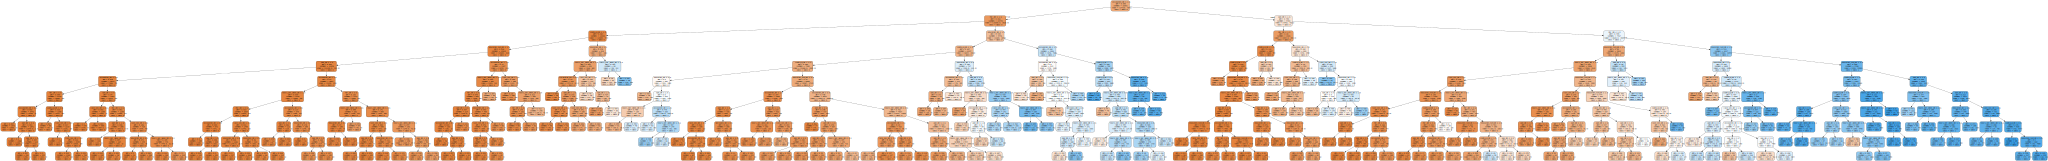

In [46]:
# Get feature names (works if x_train is a DataFrame)
feature_names = list(x_train.columns)

dot_data = export_graphviz(
    best_tree,
    out_file=None,
    feature_names=feature_names,
    class_names=["Class 0", "Class 1"],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

# 7. Conclusion

**Q.4 How long was your total run time to train the best model?**

The total runtime required to train and tune the best decision tree model was relatively short (a few seconds) due to the efficiency of the DecisionTreeClassifier algorithm and the moderate dataset size.

**Q.5 Did you find the BEST TREE?**

Yes. After systematically tuning four hyperparameters (split criterion, minimum sample leaf, maximum features, and maximum depth), the best-performing tree was identified based on the highest test accuracy. The optimal configuration was criterion = gini, min_samples_leaf = 30, max_features = sqrt, and max_depth = 10.

**Q.6 Write your observations from the visualization of the best tree**

The visualization shows that age_bin is the root node, indicating that age is the most important feature for classification. Subsequent splits involve variables such as occupation_bin, hours_per_week_bin, and marital-status-related features, suggesting that demographic and work-related characteristics strongly influence predictions. The tree structure demonstrates clear hierarchical decision rules where early splits separate large portions of the data before finer refinements occur deeper in the tree.

**Q.7 Will this Tree “overfit”?**

The tree is unlikely to significantly overfit because it is not fully grown. Constraints such as max_depth = 10 and min_samples_leaf = 30 limit excessive branching and prevent the model from memorizing the training data. These restrictions help maintain generalization performance on unseen data.

# 8. Prediction using your “trained” Decision Tree Model

In [47]:
new_indv = train.copy()
new_indv = new_indv.drop(new_indv.index)
new_indv.loc[len(new_indv)] = {
    'hours_per_week_bin' : 2.0,
    'occupation_bin' : 1.0,
    'msr_bin' : 2.0,
    'capital_gl_bin' : 2.0,
    'race_sex_bin' : 1.0,
    'education_num_bin' : 1.0,
    'education_bin' : 4.0,
    'workclass_bin' : 1.0,
    'age_bin' : 3.0,
    'flag' : None,
    'y' : None
}

In [48]:
new_indv

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,2.0,1.0,2.0,2.0,1.0,1.0,4.0,1.0,3.0,None,None


In [49]:
new_indv_test = new_indv.drop(columns=['y', 'flag'])
new_indv_best = best_tree.predict(new_indv_test)
new_indv_best

array([1])

In [50]:
# Get probability scores
probability = best_tree.predict_proba(new_indv_test)

probability


array([[0.47572816, 0.52427184]])

**Q8. What is the probability that your prediction for this person is correct?**

The trained Decision Tree predicts that the individual belongs to the >50K income category with a probability of 0.5243 (52.43%).
This indicates the model is moderately confident in its prediction.